<a href="https://colab.research.google.com/github/Ravenha/DS-Unit-2-Regression-Classification/blob/master/Bethany_assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# Import libraries
import pandas as pd
import requests
import urllib.request
import time
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib import pyplot
from sklearn.decomposition import PCA
from collections import OrderedDict
from datetime import date
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
from itertools import groupby
from math import sqrt
from numpy import linalg as LA
from mpl_toolkits import mplot3d
from numpy.linalg import matrix_rank
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mlxtend.plotting import category_scatter
from sklearn.linear_model import LinearRegression
from ipywidgets import interact

In [0]:
train = df[(df['SALE_DATE']>='2019-01') & (df['SALE_DATE']<='2019-03-31')].reset_index()
test = df[(df['SALE_DATE']>='2019-4-01') & (df['SALE_DATE']<='2019-04-30')].reset_index()

In [0]:
df = df[(df['SALE_PRICE']>=100) & (df['SALE_PRICE']<=2000000)]
df = df[(df['BUILDING_CLASS_CATEGORY']=='01 ONE FAMILY DWELLINGS') & (df['BUILDING_CLASS_CATEGORY']=='01 ONE FAMILY DWELLINGS')]
df.drop(columns=['BUILDING_CLASS_CATEGORY'], inplace=True)

In [0]:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'])

In [8]:
df.head()

,BOROUGH,NEIGHBORHOOD,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OCEAN PARKWAY-NORTH,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01
61,4,QUEENS VILLAGE,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,2019-01-01
78,2,PELHAM PARKWAY SOUTH,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,2019-01-02
108,3,FLATBUSH-CENTRAL,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,2019-01-02
111,3,FLATBUSH-EAST,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,2019-01-02


In [9]:
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT',
       'EASE-MENT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER',
       'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')

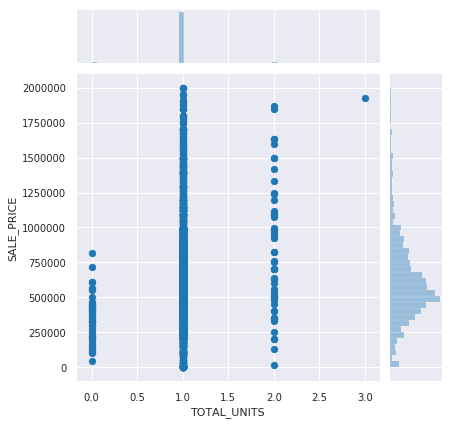

In [32]:
sns.set_style('darkgrid')
sns.jointplot(x=df['TOTAL_UNITS'], y=df['SALE_PRICE']);

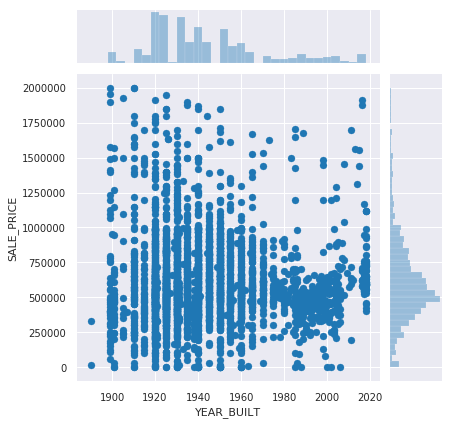

In [33]:
sns.set_style('darkgrid')
sns.jointplot(x=df['YEAR_BUILT'], y=df['SALE_PRICE']);

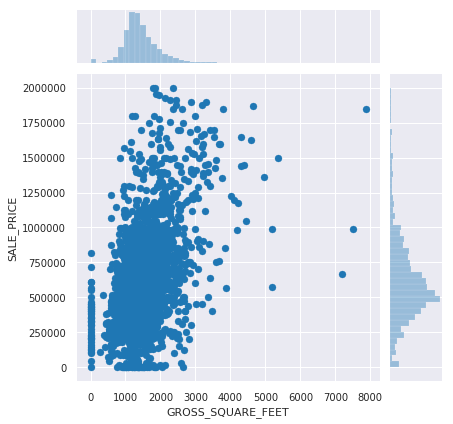

In [12]:
sns.set_style('darkgrid')
sns.jointplot(x=df['GROSS_SQUARE_FEET'], y=df['SALE_PRICE']);

In [0]:
X = df.iloc[:, [2, 3]].values

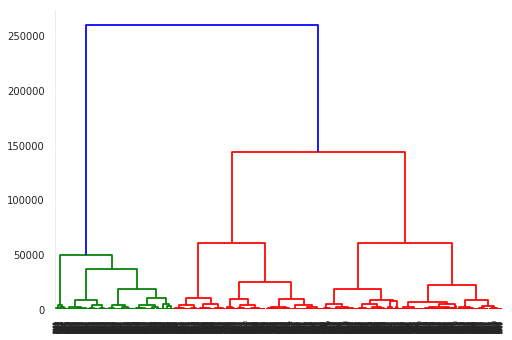

In [47]:
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))

In [0]:
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift
from sklearn.datasets.samples_generator import make_blobs
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
ms = MeanShift()
ms.fit(X)
cluster_centers = ms.cluster_centers_

In [13]:
df.shape

(3233, 20)

In [14]:
df['APARTMENT_NUMBER'].unique()

array([nan, 'RP.'], dtype=object)

In [15]:
df['APARTMENT_NUMBER'].value_counts()

RP.    1
Name: APARTMENT_NUMBER, dtype: int64

In [16]:
df[df['APARTMENT_NUMBER']=='RP.']

,BOROUGH,NEIGHBORHOOD,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
5351,5,MIDLAND BEACH,1,3809,32,NaN,A5,"143 BADEN PLACE, RP.",RP.,10306.0,1.0,0.0,1.0,800,1000.0,1989.0,1,A5,248000,2019-01-28


In [17]:
df['TAX_CLASS_AT_TIME_OF_SALE'].unique()

array([1])

In [18]:
df['EASE-MENT'].unique()

array([nan])

In [19]:
df['ADDRESS'].unique().shape

(3211,)

In [0]:
df.drop(columns=['ADDRESS', 'EASE-MENT', 'TAX_CLASS_AT_TIME_OF_SALE', 'APARTMENT_NUMBER', 'TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_PRESENT'], inplace=True)

In [0]:
df['BOROUGH'] = df['BOROUGH'].astype(str)
df['ZIP_CODE'] = df['ZIP_CODE'].astype(str)

In [28]:
df.profile_report()

In [0]:
train = df[(df['SALE_DATE']>='2019-01') & (df['SALE_DATE']<='2019-03-31')].reset_index()
test = df[(df['SALE_DATE']>='2019-4-01') & (df['SALE_DATE']<='2019-04-30')].reset_index()

In [0]:
def lr(train, test, features, target):
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]

    model = LR()
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    print(f'Linear Regression with {len(features)} features')
    print('Intercept', model.intercept_)
    coefficients = pd.Series(model.coef_, features)
    print(coefficients.to_string())
    
    print('Train Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred_train)))
    print('Test Root Mean Square Error:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
    print('Train Mean Absolute Error:', mean_absolute_error(y_train, y_pred_train))
    print('Test Mean Absolute Error:', mean_absolute_error(y_test, y_pred_test))
    print('Train R^2 Score:', r2_score(y_train, y_pred_train))
    print('Test R^2 Score:', r2_score(y_test, y_pred_test))

In [31]:
target = 'SALE_PRICE'
features = ['YEAR_BUILT', 'GROSS_SQUARE_FEET']
lr(train, test, features, target)

Linear Regression with 2 features
Intercept 2241156.8288044496
YEAR_BUILT          -1015.402778
GROSS_SQUARE_FEET     231.535618
Train Root Mean Squared Error: 272718.37727228826
Test Root Mean Square Error: 272076.43804223463
Train Mean Absolute Error: 200362.63382106475
Test Mean Absolute Error: 189272.9663972365
Train R^2 Score: 0.2023050175770279
Test R^2 Score: 0.22155604712957944
